In [565]:
import numpy as np 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,confusion_matrix, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, classification_report

In [566]:
iris = load_iris()
X = iris["data"][:, (2, 3)]  
y = (iris["target"] == 2).astype(np.int)[:,None]


In [567]:
Z = np.hstack([X,y])
np.random.shuffle(Z)
X= Z[:,0:2]
y = Z[:,2]

In [568]:
# Standarize the data
X = (X - np.mean(X))/np.std(X)

def split_trainTest(X,y,t):
    train_size = int((1-t) * X.shape[0])   
    return X[:train_size],X[train_size:],y[:train_size],y[train_size:]

X_train, X_test, y_train, y_test = split_trainTest(X,y,t=0.2)

In [569]:
class Linear_SVC:
    def __init__(self, C=1, max_iter=100, tol=None, learning_rate='constant',learning_rate_init=0.001, t_0=1, t_1=1000, early_stopping=False, validation_fraction=0.1,**kwargs):
        self.C = C
        self.w = np.random.rand(2,1)
        self.b = 0
        #self.w = np.reshape(np.array([[1.60381071, 3.05536121]]),(2,1))
        #self.b = -1.13503736      
        self.epochs = max_iter
        self.lr_sc = learning_rate
        self.learning_rate = learning_rate_init
        self.tol = tol 
        self.t_0 = t_0
        self.t_1 = t_1
        self.loss = 1e5
        self.intercept_ = None
        self.coef_ = None
        self.support_vectors_ = None
    
    def fit(self,X,y):
        ##ADd early_stopping like Assignment 3
        epch_counter = 0            
        
        while epch_counter < self.epochs:
            loss = self.loss
            epch_counter += 1
            #print(f'Epoch: {epch_counter}')
            #pdb.set_trace()
            w = self.w
            b = self.b
            if(self.lr_sc == "adaptive"):
                self.learning_rate = self.t_0 /(epch_counter + self.t_1)    
            
            t = (2*y-1)[:,None]
            
            #idx_sv = ((t*X)@w < 1).ravel()    
            idx_sv = ((t*(X@w+b)) < 1).ravel()
            X_sv = X[idx_sv]
            t_sv = t[idx_sv]
            
            self.loss = ((0.5 * (w.T @ w))+ (self.C*(np.sum(1- X_sv@w) - b* np.sum(t_sv)))).item()
            #self.loss = ((0.5 * (w.T @ w))+ (self.C*np.sum((np.maximum(0,1-t*(X@w+b)))))).item()
            print(self.loss)
            dw = w - (self.C * np.sum(X_sv))
            db = -self.C * np.sum(t_sv)
            
            self.w = w - self.learning_rate * dw
            self.b = b - self.learning_rate * db
            self.support_vectors_ = X_sv
            ## Assing intercept,Coef and Support vec
            
            if(self.tol != None and np.abs(self.loss - loss) < tol):         
                break
        self.coef_ = np.array([w])
        self.intercept_ = np.array([b])
    def predict(self,X):
        return ((X@self.coef_[0] + self.intercept_[0]) >= 1).astype(np.int)
        
        

In [570]:
model = Linear_SVC(max_iter = 35,C=10,learning_rate_init=0.001)

In [571]:
import pdb

model.fit(X_train,y_train)

1305.9666952245225
1158.6763025601451
742.9615815262522
260.7989945115656
-21.431882719182727
-125.13152359879452
-225.61670570933066
-300.9001656757679
-359.0056982830077
-389.6861816830796
-412.52268341278875
-457.74431861019866
-442.0782803023131
-476.8642109290903
-511.57485087243555
-546.2103763820331
-551.884591584852
-551.6460701151032
-578.4459863318881
-605.1945248054446
-631.8918060345925
-581.3185540342847
-602.065703570894
-622.7687742950536
-643.42786971917
-663.9809094734593
-684.1630822244117
-704.2138062076195
-724.522210547733
-639.4466013517557
-654.1399427135216
-668.7318010258485
-683.2980993717512
-697.8388980300446
-712.3542571498608


In [572]:
print(model.coef_,model.intercept_)

[[[5.77998851]
  [5.8870141 ]]] [-4.04]


In [573]:
model.support_vectors_

array([[ 1.08463802, -0.52514796],
       [ 1.40659522, -0.52514796],
       [ 1.40659522, -0.47148843],
       [ 1.13829755, -0.57880749],
       [ 1.35293568, -0.41782889],
       [ 1.08463802, -0.41782889],
       [ 1.24561662, -0.36416936],
       [ 1.19195709, -0.57880749],
       [ 1.19195709, -0.47148843],
       [ 1.08463802, -0.52514796],
       [ 1.08463802, -0.52514796],
       [ 1.08463802, -0.47148843],
       [ 1.08463802, -0.52514796],
       [ 1.35293568, -0.52514796]])

In [574]:
def decision_boundary_support_vectors(svm_clf, X):
    
    xmin, xmax = X.min() - 1, X.max() + 1
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]
    #w = np.array([[1.60381071, 3.05536121]])[0]
    #b = np.array([-1.13503736])[0]
    

    # At the decision boundary, w1*x1 + w2*x2 + b = 0
    # => x2 = -(b + w1* x1)/w1
    x1 = np.linspace(xmin, xmax, 100)    
    decision_boundary = -(b + w[0]*x1)/w[1]
    shifting_factor_for_margin = 1/w[1]
    upper_margin = decision_boundary + shifting_factor_for_margin
    lower_margin = decision_boundary - shifting_factor_for_margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=200, facecolors='g', label="Support Vectors")
    plt.plot(x1, decision_boundary, "k-", linewidth=2)
    plt.plot(x1, upper_margin, "k--", linewidth=2)
    plt.plot(x1, lower_margin, "k--", linewidth=2)

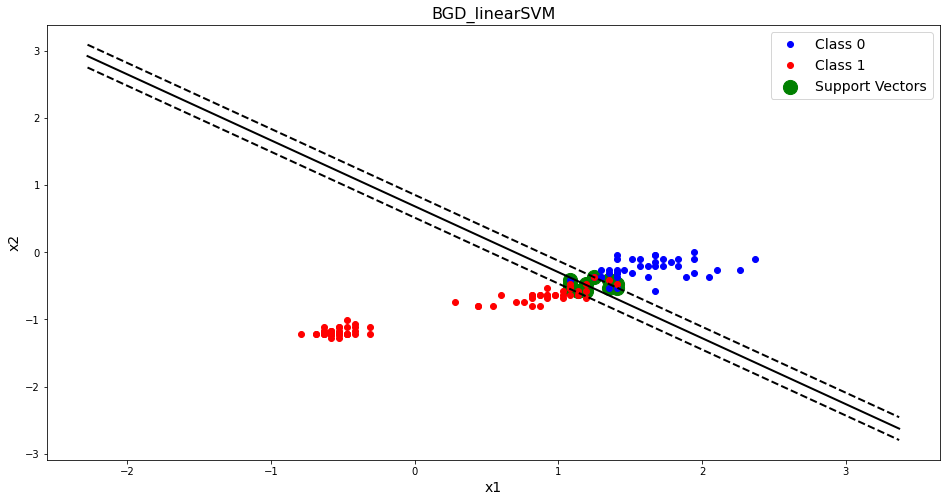

In [575]:
plt.figure(figsize=(16,8))
plt.plot(X_train[:, 0][y_train==1], X_train[:, 1][y_train==1], "bo", label="Class 0")
plt.plot(X_train[:, 0][y_train==0], X_train[:, 1][y_train==0], "ro", label="Class 1")

decision_boundary_support_vectors(model, X_train)

plt.xlabel("x1", fontsize=14)
plt.ylabel("x2", fontsize=14)
plt.legend(loc="best", fontsize=14)
plt.title("BGD_linearSVM", fontsize=16)
#plt.axis([-4, 4, -4, 4])
plt.show()

In [577]:
y_test

array([0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.])

In [580]:
y_test_predicted.squeeze()

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0])

In [576]:
pred = model.predict(X_train)
print("Train Accuracy: ", accuracy_score(pred, y_train))


y_test_predicted = model.predict(X_test)
print("Test Accuracy: ", accuracy_score(y_test_predicted, y_test))


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_test)


print("\nClassification Report:")
#print(classification_report(y_test, y_test_predicted))

Train Accuracy:  0.95
Test Accuracy:  1.0

Test Confusion Matrix:
[[21  0]
 [ 0  9]]

Test Precision = 1.000000
Test Recall = 1.000000
Test F1 Score = 1.000000

Classification Report:
